In [1]:
!pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import gc
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')



In [3]:
all_data_df = pd.read_csv("./Data/Data.csv")
ss = pd.read_csv("SampleSubmission.csv")

In [4]:
### CHANGE NAME OF FOLDER AND FILES TO CORRESPOND ####
climate_data=pd.read_excel("./ClimateData/Climate Data/Kalam Climate Data.xlsx")
climate_data.head

<bound method NDFrame.head of                 Date Time  Temperature (°C)  Dewpoint Temperature (°C)  \
0     2023-06-03 13:00:00          7.199731                  -2.448126   
1     2023-06-03 14:00:00          6.000620                  -2.597540   
2     2023-06-03 15:00:00          4.789972                  -2.696951   
3     2023-06-03 16:00:00          3.158746                  -2.879324   
4     2023-06-03 17:00:00          1.671426                  -3.255606   
...                   ...               ...                        ...   
12223 2024-10-24 20:00:00         -5.387305                  -5.942435   
12224 2024-10-24 21:00:00         -6.008307                  -6.837256   
12225 2024-10-24 22:00:00         -6.535742                  -7.863989   
12226 2024-10-24 23:00:00         -6.864859                  -8.328970   
12227 2024-10-25 00:00:00         -7.224661                  -8.735220   

       U Wind Component (m/s)  V Wind Component (m/s)  \
0                   -0.0

In [5]:
# Count the number of missing values per feature
missing_values = climate_data.isnull().sum()

# Display columns with missing values and their count
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [6]:
# Split 'Source' into 'consumer_device_X' and 'data_user_Y'
all_data_df[['consumer_device', 'data_user']] = all_data_df['Source'].str.extract(r'(consumer_device_\d+)_data_user_(\d+)')

# Display the updated DataFrame (optional)
all_data_df.head()

,date_time,v_red,current,power_factor,kwh,Source,v_blue,v_yellow,consumer_device_9,consumer_device_x,consumer_device,data_user
0,2024-07-22 18:20:00,137.65,0.08,0.72,0.000661,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1
1,2024-07-22 18:25:00,122.82,0.08,0.73,0.000598,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1
2,2024-07-22 18:30:00,119.70,0.08,0.74,0.000591,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1
3,2024-07-22 18:35:00,124.53,0.08,0.75,0.000623,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1
4,2024-07-22 18:40:00,134.84,0.08,0.74,0.000665,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1


In [7]:
# for all_data["Source"] aggregate by sum on day

import pandas as pd
# Assuming 'all_data_df' is already defined as in your previous code.
# Convert 'Datetime' column to datetime objects if it's not already
all_data_df['date_time'] = pd.to_datetime(all_data_df['date_time'])

# Extract the date part
all_data_df['Date'] = all_data_df['date_time'].dt.date

# Group by 'Source' and 'Date', then sum the 'Load' for each group
aggregated_data = all_data_df.groupby(['Source', 'Date'])['kwh'].sum().reset_index()

# Display the aggregated data
aggregated_data.head()


,Source,Date,kwh
0,consumer_device_10_data_user_1,2024-07-22,0.024330
1,consumer_device_10_data_user_1,2024-07-23,0.103560
2,consumer_device_10_data_user_1,2024-07-24,0.137543
3,consumer_device_10_data_user_1,2024-07-25,0.121011
4,consumer_device_10_data_user_1,2024-07-26,0.000000


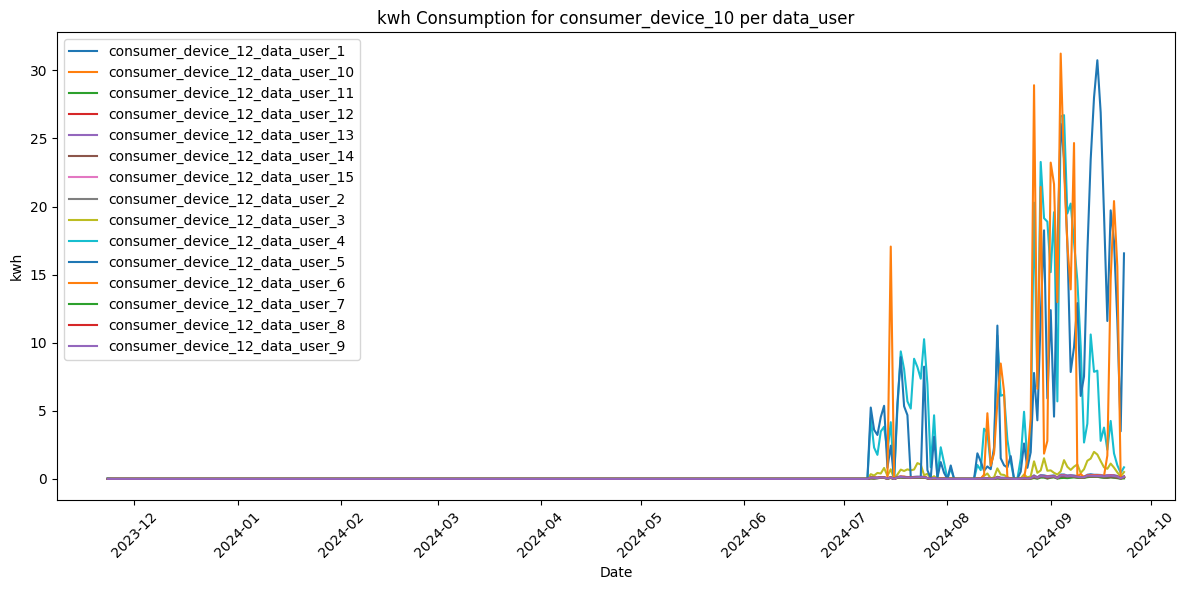

In [8]:
# Filter data for consumer_device_10
consumer_10_data = aggregated_data[aggregated_data['Source'].str.contains('consumer_device_12')]

# Create the plot
plt.figure(figsize=(12, 6))
for data_user in consumer_10_data['Source'].unique():
    user_data = consumer_10_data[consumer_10_data['Source'] == data_user]
    plt.plot(user_data['Date'], user_data['kwh'], label=data_user)

plt.xlabel('Date')
plt.ylabel('kwh')
plt.title('kwh Consumption for consumer_device_10 per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
# Find the minimum and maximum date_time values
min_date = aggregated_data['Date'].min()
max_date = aggregated_data['Date'].max()

print(f"Minimum date_time: {min_date}")
print(f"Maximum date_time: {max_date}")

Minimum date_time: 2023-06-03
Maximum date_time: 2024-09-23


In [10]:
# Fill missing date values with 0 kwh

# Create a date range
date_rng = pd.date_range(start=min_date, end=max_date, freq='D')

# Create an empty DataFrame to store the complete data
complete_data = pd.DataFrame()

# Iterate through each unique 'Source'
for source in aggregated_data['Source'].unique():
    # Extract data for the current 'Source'
    source_data = aggregated_data[aggregated_data['Source'] == source].copy()

    # Convert the source data Date to match the type of date_rng
    source_data['Date'] = pd.to_datetime(source_data['Date'])

    # Create a complete date range for the current 'Source'
    source_date_rng = pd.DataFrame({'Date': date_rng})
    source_date_rng['Source'] = source

    # Merge with the existing data, filling missing 'kwh' values with 0
    source_data = pd.merge(source_date_rng, source_data, on=['Date', 'Source'], how='left')
    # source_data['kwh'] = source_data['kwh'].fillna(0)
    source_data = source_data.dropna()
    # Append to the complete data
    complete_data = pd.concat([complete_data, source_data], ignore_index=True)

In [11]:
### CHANGE NAME OF FOLDER AND FILES TO CORRESPOND ####
climate_df = pd.read_excel("./ClimateData/Climate Data/Kalam Climate Data.xlsx")# Convert to datetime
complete_data["Date"] = pd.to_datetime(complete_data["Date"])
climate_df["Date Time"] = pd.to_datetime(climate_df["Date Time"])

# Aggregate climate data to daily level
climate_daily = climate_df.groupby(climate_df["Date Time"].dt.date).agg({
    "Temperature (°C)": "mean",
    "Dewpoint Temperature (°C)": "mean",
    "U Wind Component (m/s)": "mean",
    "V Wind Component (m/s)": "mean",
    "Total Precipitation (mm)": "sum",
    "Snowfall (mm)": "sum",
    "Snow Cover (%)": "mean",
}).reset_index()

# Convert 'Date' column in climate_daily to datetime format
climate_daily.rename(columns={"Date Time": "Date"}, inplace=True)
climate_daily["Date"] = pd.to_datetime(climate_daily["Date"])  # Ensure datetime64[ns]

# Merge with complete_data
complete_data = complete_data.merge(climate_daily, on="Date", how="left")

In [12]:
days = max_date - min_date

In [13]:
# Extract consumer device and data user using regex
complete_data["consumer_device"] = complete_data["Source"].str.extract(r'consumer_device_(\d+)_data_user_\d+').astype(int)
complete_data["data_user"] = complete_data["Source"].str.extract(r'consumer_device_\d+_data_user_(\d+)').astype(int)

In [14]:
import pandas as pd
import numpy as np

# Convert 'Date' to datetime format if not already
complete_data["Date"] = pd.to_datetime(complete_data["Date"])

# Extract date features (keeping only useful ones)
complete_data["year"] = complete_data["Date"].dt.year
complete_data["day"] = complete_data["Date"].dt.day
complete_data["is_weekend"] = (complete_data["Date"].dt.dayofweek >= 5).astype(int)  # 1 if Sat/Sun, else 0

# Sinusoidal encoding of cyclical features
complete_data["day_of_week_sin"] = np.sin(2 * np.pi * complete_data["Date"].dt.dayofweek / 7)
complete_data["day_of_week_cos"] = np.cos(2 * np.pi * complete_data["Date"].dt.dayofweek / 7)

complete_data["month_sin"] = np.sin(2 * np.pi * complete_data["Date"].dt.month / 12)
complete_data["month_cos"] = np.cos(2 * np.pi * complete_data["Date"].dt.month / 12)

complete_data["week_of_year_sin"] = np.sin(2 * np.pi * complete_data["Date"].dt.isocalendar().week / 52)
complete_data["week_of_year_cos"] = np.cos(2 * np.pi * complete_data["Date"].dt.isocalendar().week / 52)

complete_data["quarter_sin"] = np.sin(2 * np.pi * complete_data["Date"].dt.quarter / 4)
complete_data["quarter_cos"] = np.cos(2 * np.pi * complete_data["Date"].dt.quarter / 4)



In [15]:
complete_data

,Date,Source,kwh,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%),...,day,is_weekend,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,quarter_sin,quarter_cos
0,2024-07-22,consumer_device_10_data_user_1,0.024330,14.719596,8.280669,0.022655,-0.104998,0.073049,0.000000,0.000000,...,22,0,0.000000,1.000000,-0.5,-8.660254e-01,-0.464723,-0.885456,-1.0,-1.836970e-16
1,2024-07-23,consumer_device_10_data_user_1,0.103560,13.217268,9.862700,0.116137,-0.077997,0.121921,0.000000,0.000000,...,23,0,0.781831,0.623490,-0.5,-8.660254e-01,-0.464723,-0.885456,-1.0,-1.836970e-16
2,2024-07-24,consumer_device_10_data_user_1,0.137543,12.462190,9.865658,0.103451,-0.075028,0.119984,0.000000,0.000000,...,24,0,0.974928,-0.222521,-0.5,-8.660254e-01,-0.464723,-0.885456,-1.0,-1.836970e-16
3,2024-07-25,consumer_device_10_data_user_1,0.121011,13.867551,8.973798,0.066345,-0.043182,0.034283,0.000000,0.000000,...,25,0,0.433884,-0.900969,-0.5,-8.660254e-01,-0.464723,-0.885456,-1.0,-1.836970e-16
4,2024-07-26,consumer_device_10_data_user_1,0.000000,15.572609,9.434734,0.093025,0.046414,0.006961,0.000000,0.000000,...,26,0,-0.433884,-0.900969,-0.5,-8.660254e-01,-0.464723,-0.885456,-1.0,-1.836970e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136404,2024-09-10,consumer_device_9_data_user_9,0.000000,8.972100,4.735042,0.100475,0.099872,0.012961,0.000000,0.000000,...,10,0,0.781831,0.623490,-1.0,-1.836970e-16,-0.970942,-0.239316,-1.0,-1.836970e-16
136405,2024-09-11,consumer_device_9_data_user_9,0.000000,9.216674,2.945390,0.031060,-0.080538,0.014010,0.000000,0.000000,...,11,0,0.974928,-0.222521,-1.0,-1.836970e-16,-0.970942,-0.239316,-1.0,-1.836970e-16
136406,2024-09-12,consumer_device_9_data_user_9,0.000000,10.711587,1.898337,-0.069007,-0.089148,0.002685,0.000000,0.000000,...,12,0,0.433884,-0.900969,-1.0,-1.836970e-16,-0.970942,-0.239316,-1.0,-1.836970e-16
136407,2024-09-13,consumer_device_9_data_user_9,0.000000,10.078417,3.285115,0.170258,0.271345,0.009149,0.000000,0.000000,...,13,0,-0.433884,-0.900969,-1.0,-1.836970e-16,-0.970942,-0.239316,-1.0,-1.836970e-16


In [16]:
complete_data.columns

Index(['Date', 'Source', 'kwh', 'Temperature (°C)',
       'Dewpoint Temperature (°C)', 'U Wind Component (m/s)',
       'V Wind Component (m/s)', 'Total Precipitation (mm)', 'Snowfall (mm)',
       'Snow Cover (%)', 'consumer_device', 'data_user', 'year', 'day',
       'is_weekend', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'quarter_sin',
       'quarter_cos'],
      dtype='object')

# CLEANING

In [17]:
# These are the devices that are not in the test SampleSubmission

devices_to_drop = ["consumer_device_3","consumer_device_5","consumer_device_11", "consumer_device_14",
                   "consumer_device_15", "consumer_device_17", "consumer_device_24",
                   "consumer_device_25","consumer_device_27","consumer_device_33","consumer_device_4","consumer_device_9"]

In [18]:
filtered_df = complete_data[complete_data['Source'].str.startswith(tuple(devices_to_drop))]
filtered_df.head()


,Date,Source,kwh,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%),...,day,is_weekend,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,quarter_sin,quarter_cos
1152,2023-10-01,consumer_device_11_data_user_1,1.739986,-0.356678,-8.421920,0.064102,-0.773024,0.001031,0.000268,71.363607,...,1,1,-0.781831,0.623490,-0.866025,0.5,-1.0,-0.0,-2.449294e-16,1.0
1153,2023-10-02,consumer_device_11_data_user_1,3.745510,0.640565,-4.417801,0.201683,-0.425513,0.012289,0.001962,47.134440,...,2,0,0.000000,1.000000,-0.866025,0.5,-0.992709,0.120537,-2.449294e-16,1.0
1154,2023-10-03,consumer_device_11_data_user_1,3.846065,1.269988,-4.233044,-0.020184,-0.633934,0.006746,0.000190,27.332601,...,3,0,0.781831,0.623490,-0.866025,0.5,-0.992709,0.120537,-2.449294e-16,1.0
1155,2023-10-04,consumer_device_11_data_user_1,2.494146,3.635788,-5.681771,-0.068363,-0.678879,0.000507,0.000004,14.637614,...,4,0,0.974928,-0.222521,-0.866025,0.5,-0.992709,0.120537,-2.449294e-16,1.0
1156,2023-10-05,consumer_device_11_data_user_1,2.106918,4.786071,-4.828240,-0.234774,-0.672235,0.000017,0.000000,7.346029,...,5,0,0.433884,-0.900969,-0.866025,0.5,-0.992709,0.120537,-2.449294e-16,1.0


In [19]:
def check_save_pred(forecast_pred, data, sss, file_name="forecast.csv"):
    print(forecast_pred.head())
    forecast_pred["kwh"] = forecast_pred["kwh"].fillna(0)
    # prompt: list the difference in the ID between forecast and ss
    print(len(data), len(forecast_pred), len(sss))
    # Assuming 'forecast' and 'ss' DataFrames are already defined as in your provided code.
    forecast_pred.to_csv(file_name, index = False)
    # Convert 'ID' columns to sets for efficient comparison
    forecast_ids = set(forecast_pred['ID'])
    ss_ids = set(sss['ID'])
    
    # Find IDs present in forecast but not in ss
    forecast_only_ids = forecast_ids - ss_ids
    
    # Find IDs present in ss but not in forecast
    ss_only_ids = ss_ids - forecast_ids
    
    # Print the IDs that are in forecast but not in ss
    print("IDs in 'forecast' but not in 'ss':")
    print(forecast_only_ids)
    
    
    # Print the IDs that are in ss but not in forecast
    print("\nIDs in 'ss' but not in 'forecast':")
    print(ss_only_ids)
    
    # Print the number of IDs that differ
    print(f"\nNumber of IDs that differ: {len(forecast_only_ids) + len(ss_only_ids)}")

In [20]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Function to process and forecast per unique consumer_device_x and data_user_y
def forecast_arima(all_data, forecast_horizon=30, output_template=None):
    # Store forecasts
    forecast_results = []

    # Process each unique consumer_device_x and data_user_y combination
    for (consumer_device, data_user), group in all_data.groupby(["consumer_device", "data_user"]):
        # Set Date as index
        group = group.set_index("Date")

        # Ensure data is in the correct format
        group = group.asfreq('D').fillna(method='ffill')  # Fill missing dates with last known value

        # Fit ARIMA model
        try:
            model = ARIMA(group["kwh"], order=(7, 1, 3))  # ARIMA(5,1,0) as a baseline
            fitted_model = model.fit()

            # Forecast for the next forecast_horizon days
            forecast_dates = pd.date_range(start=group.index[-1] + pd.Timedelta(days=1),
                                           periods=forecast_horizon, freq='D')
            forecast_values = fitted_model.forecast(steps=forecast_horizon)

            # Store results in required format
            forecast_df = pd.DataFrame({
                "ID": [f"{date.strftime('%Y-%m-%d')}_consumer_device_{consumer_device}_data_user_{data_user}"
                        for date in forecast_dates],
                "kwh": forecast_values
            })

            forecast_results.append(forecast_df)

        except Exception as e:
            print(f"Error processing {consumer_device}_{data_user}: {e}")

    # Combine all forecasts into a single DataFrame
    forecast_df = pd.concat(forecast_results, ignore_index=True)

    # If an output template is provided, align the output format
    if output_template is not None:
        output_template = output_template.drop(columns=['kwh'], errors='ignore')
        final_output = output_template.merge(forecast_df, on='ID', how='left').fillna(0)
    else:
        final_output = forecast_df

    return final_output


In [26]:
forecast_arima = forecast_arima(all_data=complete_data, forecast_horizon=30, output_template=ss)

In [34]:
forecast_arima

,ID,kwh
0,2024-09-24_consumer_device_12_data_user_1,0.165630
1,2024-09-25_consumer_device_12_data_user_1,0.159924
2,2024-09-26_consumer_device_12_data_user_1,0.205964
3,2024-09-27_consumer_device_12_data_user_1,0.185630
4,2024-09-28_consumer_device_12_data_user_1,0.160174
...,...,...
6009,2024-10-20_consumer_device_8_data_user_9,0.268298
6010,2024-10-21_consumer_device_8_data_user_9,0.268629
6011,2024-10-22_consumer_device_8_data_user_9,0.267906
6012,2024-10-23_consumer_device_8_data_user_9,0.268044


In [27]:
forecast_arima=(forecast_arima.copy())
forecast_arima.loc[forecast_arima['kwh'] < 0, 'kwh'] = 0

In [28]:
 check_save_pred(forecast_pred=forecast_arima, data=complete_data, sss=ss, file_name="forecast_arima.csv")

                                          ID       kwh
0  2024-09-24_consumer_device_12_data_user_1  0.165220
1  2024-09-25_consumer_device_12_data_user_1  0.158772
2  2024-09-26_consumer_device_12_data_user_1  0.205351
3  2024-09-27_consumer_device_12_data_user_1  0.185120
4  2024-09-28_consumer_device_12_data_user_1  0.159856
136409 6014 6014
IDs in 'forecast' but not in 'ss':
set()

IDs in 'ss' but not in 'forecast':
set()

Number of IDs that differ: 0


In [29]:
X = complete_data.drop(columns=['Date','Source', 'kwh'])
y = complete_data.kwh
X.fillna(-1,inplace=True)
from sklearn.model_selection import *
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, 
                                                    shuffle=True, stratify=X['consumer_device'])
from catboost import *
model_cat = CatBoostRegressor(iterations=12000, loss_function='RMSE', use_best_model=True,
                          early_stopping_rounds=100, verbose=100, random_state=42,
                          )
model_cat.fit(X_train, y_train, eval_set=(X_test, y_test))

Learning rate set to 0.023129
0:	learn: 3.7152810	test: 3.8320460	best: 3.8320460 (0)	total: 118ms	remaining: 23m 32s
100:	learn: 3.1513266	test: 3.3294533	best: 3.3294533 (100)	total: 1.02s	remaining: 1m 59s
200:	learn: 2.8826772	test: 3.0544146	best: 3.0544146 (200)	total: 1.83s	remaining: 1m 47s
300:	learn: 2.7257418	test: 2.8867842	best: 2.8867842 (300)	total: 2.6s	remaining: 1m 41s
400:	learn: 2.6216137	test: 2.7777265	best: 2.7777265 (400)	total: 3.4s	remaining: 1m 38s
500:	learn: 2.5377569	test: 2.6900656	best: 2.6900656 (500)	total: 4.16s	remaining: 1m 35s
600:	learn: 2.4574617	test: 2.6050082	best: 2.6050082 (600)	total: 4.92s	remaining: 1m 33s
700:	learn: 2.3954892	test: 2.5336694	best: 2.5336694 (700)	total: 5.69s	remaining: 1m 31s
800:	learn: 2.3404594	test: 2.4702360	best: 2.4702360 (800)	total: 6.46s	remaining: 1m 30s
900:	learn: 2.2992633	test: 2.4255311	best: 2.4255311 (900)	total: 7.22s	remaining: 1m 28s
1000:	learn: 2.2652966	test: 2.3925215	best: 2.3925215 (1000)	tot

In [87]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

def forecast_arima_device_18(all_data, forecast_horizon=30):
    """
    Forecast kwh using ARIMA for only consumer_device == 18 across all data_user groups.
    Returns a DataFrame with ID and kwh_arima_18 columns.
    """
    forecast_results = []

    # Filter only for consumer_device 18
    data_device_18 = all_data[all_data["consumer_device"] == 18]

    # Group by data_user
    for data_user, group in data_device_18.groupby("data_user"):
        try:
            group = group.set_index("Date").sort_index()
            group = group.asfreq('D').fillna(method='ffill')

            model = ARIMA(group["kwh"], order=(7, 1, 3))  # Adjust (p,d,q) if needed
            fitted_model = model.fit()

            forecast_dates = pd.date_range(start=group.index[-1] + pd.Timedelta(days=1),
                                           periods=forecast_horizon, freq='D')
            forecast_values = fitted_model.forecast(steps=forecast_horizon)

            forecast_df = pd.DataFrame({
                "ID": [f"{date.strftime('%Y-%m-%d')}_consumer_device_18_data_user_{data_user}"
                       for date in forecast_dates],
                "kwh_arima_18": forecast_values
            })

            forecast_results.append(forecast_df)

        except Exception as e:
            print(f"Error processing device 18, user {data_user}: {e}")

    return pd.concat(forecast_results, ignore_index=True)


In [119]:
import pandas as pd
import numpy as np

def custom_peak_decline_forecast_per_user18(all_data, forecast_horizon=30):
    """
    Forecast for each data_user under consumer_device 18 using:
    - Days 1–3: linear increase from last_value to peak (1.05 * last_value)
    - Day 4: constant peak
    - Days 5–30: linear decline from peak to 0
    """
    forecast_results = []

    # Filter for consumer_device 18
    device_data = all_data[all_data['consumer_device'] == 18].copy()

    # Loop over each data_user under device 18
    for data_user, user_group in device_data.groupby('data_user'):
        user_group = user_group.sort_values('Date')
        last_val = user_group['kwh'].iloc[-1]
        print(last_val)
        peak_val = last_val * 1.05

        # Phase 1: increase to peak in 3 days
        phase1 = np.linspace(last_val, peak_val, 3)

        # Phase 2: flat peak at day 4
        phase2 = np.array([peak_val])

        # Phase 3: decline to 0 from day 5 to 30
        remaining_days = forecast_horizon - 4
        phase3 = np.linspace(peak_val, 0, remaining_days)

        # Combine all
        kwh_forecast = np.concatenate([phase1, phase2, phase3])

        # Forecast dates
        forecast_dates = pd.date_range(start=user_group['Date'].max() + pd.Timedelta(days=1), 
                                       periods=forecast_horizon, freq='D')

        forecast_ids = [
            f"{date.strftime('%Y-%m-%d')}_consumer_device_18_data_user_{data_user}"
            for date in forecast_dates
        ]

        forecast_df = pd.DataFrame({
            'ID': forecast_ids,
            'kwh': kwh_forecast
        })

        forecast_results.append(forecast_df)

    return pd.concat(forecast_results, ignore_index=True)


In [124]:
forecast_18_only=custom_peak_decline_forecast_per_user18(all_data=complete_data, forecast_horizon=30)

0.1976337769999879
4.097732574583321
9.897788554583322
19.27103866133332
18.79643659399999
19.067156845499987
62.474864293666656
62.60665187466665
62.26823151833332
38.19391590066665
37.59647993816665
37.36897929024999
0.2367706999999867
0.2347502320833188
0.2946528329999888
0.3629802179999905
0.2684475894999907
0.2944829761666561


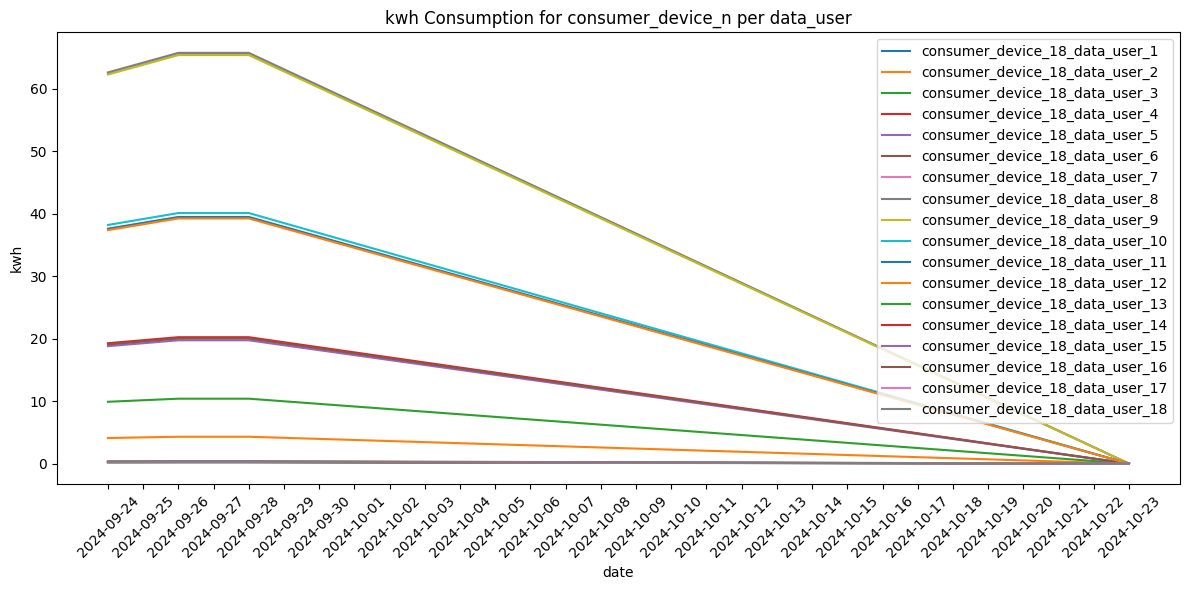

In [126]:
# Filter data for consumer_device_10
forecast_18_only['date'] = forecast_18_only['ID'].str.extract(r'^(\d{4}-\d{2}-\d{2})')
forecast_18_only['source'] = forecast_18_only['ID'].str.extract(r'^\d{4}-\d{2}-\d{2}_(.+)')
consumer_n_data = forecast_18_only[forecast_18_only['source'].str.contains('consumer_device_18')]

# Create the plot
plt.figure(figsize=(12, 6))
for data_user in consumer_n_data['source'].unique():
    user_data = consumer_n_data[consumer_n_data['source'] == data_user]
    plt.plot(user_data['date'], user_data['kwh'], label=data_user)

plt.xlabel('date')
plt.ylabel('kwh')
plt.title('kwh Consumption for consumer_device_n per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [133]:
#forecast_18_only.rename(columns={'kwh_arima_18': 'kwh'}, inplace=True)
forecast_18 = pd.read_csv("SampleSubmission.csv")

# Set ID as index for both DataFrames
forecast_18.set_index("ID", inplace=True)
#forecast_18_only.set_index("ID", inplace=True)

# Update forecast_18 with predicted kwh values where IDs match
forecast_18.update(forecast_18_only[["kwh"]])

# Reset index if needed
forecast_18.reset_index(inplace=True)


In [136]:
for_dev_18 = forecast_18[forecast_18['ID'].str.contains('consumer_device_18_data_user_10')]
for_dev_18

,ID,kwh
1240,2024-09-24_consumer_device_18_data_user_10,38.193916
1241,2024-09-25_consumer_device_18_data_user_10,39.148764
1242,2024-09-26_consumer_device_18_data_user_10,40.103612
1243,2024-09-27_consumer_device_18_data_user_10,40.103612
1244,2024-09-28_consumer_device_18_data_user_10,40.103612
1245,2024-09-29_consumer_device_18_data_user_10,38.499467
1246,2024-09-30_consumer_device_18_data_user_10,36.895323
1247,2024-10-01_consumer_device_18_data_user_10,35.291178
1248,2024-10-02_consumer_device_18_data_user_10,33.687034
1249,2024-10-03_consumer_device_18_data_user_10,32.082889


In [148]:
forecast_cat= pd.read_csv("forecast-cat_base_109.csv")
forecast_cat['date'] = forecast_cat['ID'].str.extract(r'^(\d{4}-\d{2}-\d{2})')
forecast_cat['source'] = forecast_cat['ID'].str.extract(r'^\d{4}-\d{2}-\d{2}_(.+)')

In [149]:
forecasrt_arima_v= pd.read_csv("forecast_arima.csv")
forecasrt_arima_v['date'] = forecast_cat['ID'].str.extract(r'^(\d{4}-\d{2}-\d{2})')
forecasrt_arima_v['source'] = forecast_cat['ID'].str.extract(r'^\d{4}-\d{2}-\d{2}_(.+)')

In [151]:
# First, merge both forecasts on 'ID'
combined_forecast = forecast_cat.merge(forecasrt_arima_v, on='ID', suffixes=('_cat', '_arima'))
combined_forecast = combined_forecast.merge(forecast_18[['ID', 'kwh']], on='ID', how='left')


# Extract consumer_device and source
combined_forecast['consumer_device'] = combined_forecast['ID'].str.extract(r'consumer_device_(\d+)').astype(int)
combined_forecast['source'] = combined_forecast['ID'].str.extract(r'^\d{4}-\d{2}-\d{2}_(.+)')
# Now, merge in forecast_18
combined_forecast.rename(columns={'kwh': 'kwh_18'}, inplace=True)

# Extract device/source info if not already extracted
combined_forecast['consumer_device'] = combined_forecast['ID'].str.extract(r'consumer_device_(\d+)').astype(int)
combined_forecast['source'] = combined_forecast['ID'].str.extract(r'^\d{4}-\d{2}-\d{2}_(.+)')
# Get min forecast and model source
min_forecast = combined_forecast.copy()
min_forecast['kwh'] = min_forecast[['kwh_cat', 'kwh_arima']].min(axis=1)
min_forecast['source_model'] = min_forecast.apply(
    lambda row: 'cat' if row['kwh_cat'] <= row['kwh_arima'] else 'arima',
    axis=1
)

# Get max forecast and model source
max_forecast = combined_forecast.copy()
max_forecast['kwh'] = max_forecast[['kwh_cat', 'kwh_arima']].max(axis=1)
max_forecast['source_model'] = max_forecast.apply(
    lambda row: 'cat' if row['kwh_cat'] >= row['kwh_arima'] else 'arima',
    axis=1
)

# Keep only necessary columns for final outputs
min_forecast = min_forecast[['ID', 'kwh', 'source_model']]
max_forecast = max_forecast[['ID', 'kwh', 'source_model']]


In [73]:
# Create new DataFrame based on logic: if max from 'cat' → average; else → use arima
#device_check = combined_forecast.copy()

#device_check['kwh'] = device_check.apply(
#    lambda row:
#    0 if (row['consumer_device']==32 )
#    else row['kwh_arima'],
#    axis=1
#)


# Keep only desired columns
#device_check = device_check[['ID', 'kwh']]
#check_save_pred(forecast_pred=device_check, data=complete_data, sss=ss, file_name="device_check_32.csv")
#device_check


In [146]:
# ONLY 0 if consumer_device=18
adjusted_max_forecast = combined_forecast.copy()

adjusted_max_forecast['kwh'] = adjusted_max_forecast.apply(
    lambda row:
    (row['kwh_18']) if row["consumer_device"] == 18
    else 0,
    axis=1
)


# Keep only desired columns
adjusted_max_forecast = adjusted_max_forecast[['ID', 'kwh']]


In [142]:
adjusted_max_forecast

,ID,kwh
0,2024-09-24_consumer_device_12_data_user_1,0.0
1,2024-09-25_consumer_device_12_data_user_1,0.0
2,2024-09-26_consumer_device_12_data_user_1,0.0
3,2024-09-27_consumer_device_12_data_user_1,0.0
4,2024-09-28_consumer_device_12_data_user_1,0.0
...,...,...
6009,2024-10-20_consumer_device_8_data_user_9,0.0
6010,2024-10-21_consumer_device_8_data_user_9,0.0
6011,2024-10-22_consumer_device_8_data_user_9,0.0
6012,2024-10-23_consumer_device_8_data_user_9,0.0


In [157]:
# THE BESSSSST SCORRE WITH THISSS 
adjusted_max_forecast = combined_forecast.copy()

adjusted_max_forecast['kwh'] = adjusted_max_forecast.apply(
    lambda row:
    (row['kwh_cat'] + row['kwh_arima']) / 2 if (row['kwh_cat'] > row['kwh_arima']  and  (row["consumer_device"] != 18))
    else  (1*row['kwh_cat'] + 3*row['kwh_arima']) / 4 if (row['kwh_cat'] > 21  and  (row["consumer_device"] != 18)) 
    else (row['kwh_18']) if (row["consumer_device"] == 18)
    else row['kwh_cat'],
    axis=1
)


# Keep only desired columns
adjusted_max_forecast = adjusted_max_forecast[['ID', 'kwh']]


In [66]:
adjusted_max_forecast

,ID,kwh
0,2024-09-24_consumer_device_12_data_user_1,0.000000
1,2024-09-25_consumer_device_12_data_user_1,0.000000
2,2024-09-26_consumer_device_12_data_user_1,0.000000
3,2024-09-27_consumer_device_12_data_user_1,0.000000
4,2024-09-28_consumer_device_12_data_user_1,0.000000
...,...,...
6009,2024-10-20_consumer_device_8_data_user_9,0.401051
6010,2024-10-21_consumer_device_8_data_user_9,0.439370
6011,2024-10-22_consumer_device_8_data_user_9,0.503377
6012,2024-10-23_consumer_device_8_data_user_9,0.414730


In [159]:
 check_save_pred(forecast_pred=adjusted_max_forecast, data=complete_data, sss=ss, file_name="CATARI_MIX_DEV18SETUP.csv")

                                          ID  kwh        date  \
0  2024-09-24_consumer_device_12_data_user_1  0.0  2024-09-24   
1  2024-09-25_consumer_device_12_data_user_1  0.0  2024-09-25   
2  2024-09-26_consumer_device_12_data_user_1  0.0  2024-09-26   
3  2024-09-27_consumer_device_12_data_user_1  0.0  2024-09-27   
4  2024-09-28_consumer_device_12_data_user_1  0.0  2024-09-28   

                           source  
0  consumer_device_12_data_user_1  
1  consumer_device_12_data_user_1  
2  consumer_device_12_data_user_1  
3  consumer_device_12_data_user_1  
4  consumer_device_12_data_user_1  
136409 6014 6014
IDs in 'forecast' but not in 'ss':
set()

IDs in 'ss' but not in 'forecast':
set()

Number of IDs that differ: 0


In [143]:
# prompt: TEST RMSE COMPARED TO CATBOOST

import pandas as pd
from sklearn.metrics import mean_squared_error
import math
forecast_best= pd.read_csv("forecast-cat_base_109.csv")

# Assuming 'forecast' and 'ss' are DataFrames with a common 'ID' column and a 'kwh' column
# containing the forecast and actual values respectively.

# Merge the forecast and ss DataFrames on the 'ID' column
merged_df = pd.merge(adjusted_max_forecast, forecast_best, on='ID', how='left', suffixes=('_forecast', '_actual'))

# Calculate the RMSE
rmse = math.sqrt(mean_squared_error(merged_df['kwh_actual'], merged_df['kwh_forecast']))

print(f"RMSE: {rmse}")


RMSE: 7.028952368697547


In [43]:
# Filter rows where kwh > 12
high_kwh_sources = forecast_cat[forecast_cat['kwh'] > 20]['source'].unique()

# Print each source
for source in high_kwh_sources:
    print(source)


consumer_device_13_data_user_4
consumer_device_18_data_user_10
consumer_device_18_data_user_11
consumer_device_18_data_user_12
consumer_device_18_data_user_4
consumer_device_18_data_user_5
consumer_device_18_data_user_6
consumer_device_18_data_user_7
consumer_device_18_data_user_8
consumer_device_18_data_user_9
consumer_device_21_data_user_10
consumer_device_21_data_user_3
consumer_device_23_data_user_2
consumer_device_29_data_user_3
consumer_device_2_data_user_1
consumer_device_32_data_user_19


In [44]:
# Filter rows where kwh > 12
l_kwh_sources = forecasrt_arima_v[forecasrt_arima_v['kwh'] > 20]['source'].unique()

# Print each source
for source in l_kwh_sources:
    print(source)


consumer_device_12_data_user_5
consumer_device_18_data_user_10
consumer_device_18_data_user_11
consumer_device_18_data_user_12
consumer_device_18_data_user_4
consumer_device_18_data_user_5
consumer_device_18_data_user_6
consumer_device_18_data_user_7
consumer_device_18_data_user_8
consumer_device_18_data_user_9
consumer_device_21_data_user_10
consumer_device_21_data_user_3
consumer_device_21_data_user_5
consumer_device_23_data_user_2
consumer_device_23_data_user_4
consumer_device_29_data_user_3
consumer_device_29_data_user_7
consumer_device_2_data_user_1
consumer_device_32_data_user_19
consumer_device_32_data_user_5


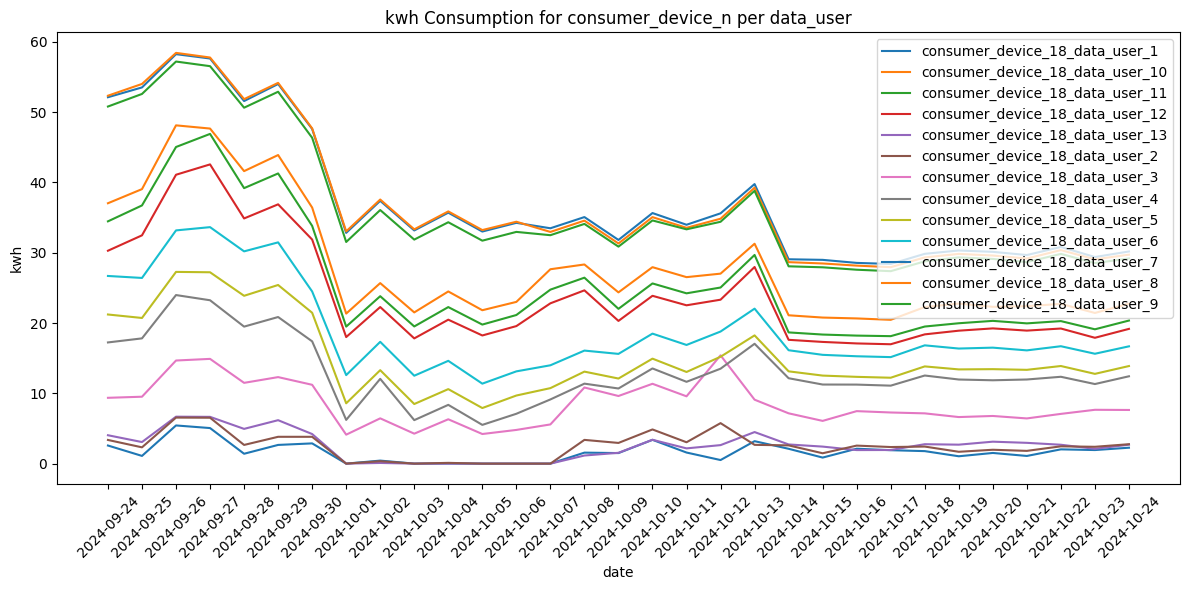

In [50]:
# Filter data for consumer_device_10
consumer_n_data = forecast_cat[forecast_cat['source'].str.contains('consumer_device_18')]

# Create the plot
plt.figure(figsize=(12, 6))
for data_user in consumer_n_data['source'].unique():
    user_data = consumer_n_data[consumer_n_data['source'] == data_user]
    plt.plot(user_data['date'], user_data['kwh'], label=data_user)

plt.xlabel('date')
plt.ylabel('kwh')
plt.title('kwh Consumption for consumer_device_n per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


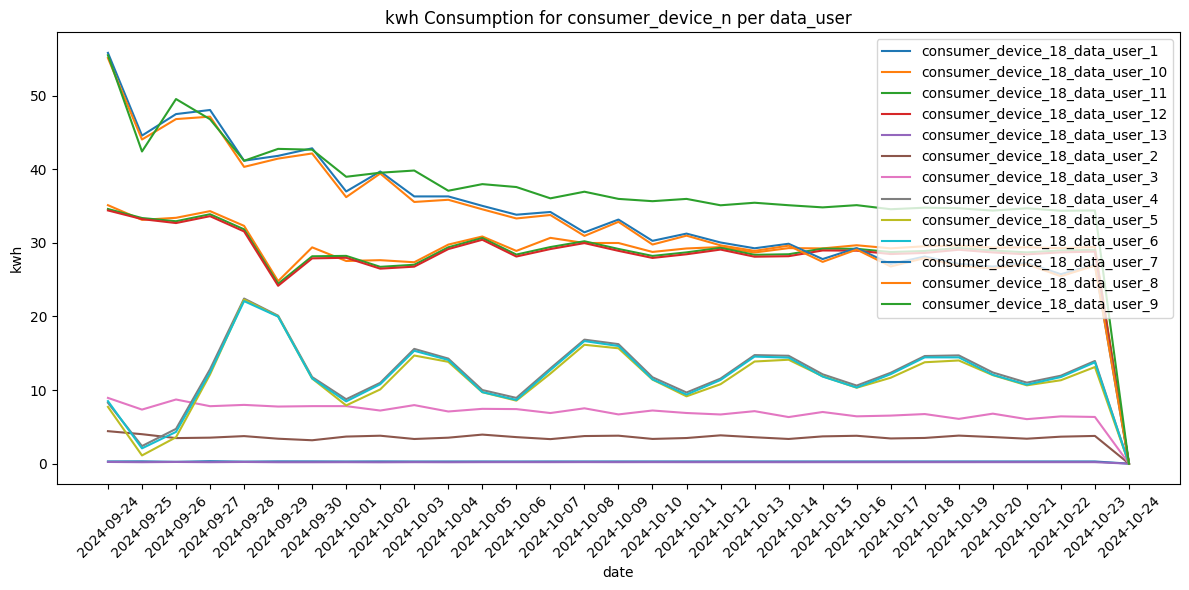

In [51]:
# Filter data for consumer_device_10
consumer_n_data = forecasrt_arima_v[forecasrt_arima_v['source'].str.contains('consumer_device_18')]

# Create the plot
plt.figure(figsize=(12, 6))
for data_user in consumer_n_data['source'].unique():
    user_data = consumer_n_data[consumer_n_data['source'] == data_user]
    plt.plot(user_data['date'], user_data['kwh'], label=data_user)

plt.xlabel('date')
plt.ylabel('kwh')
plt.title('kwh Consumption for consumer_device_n per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


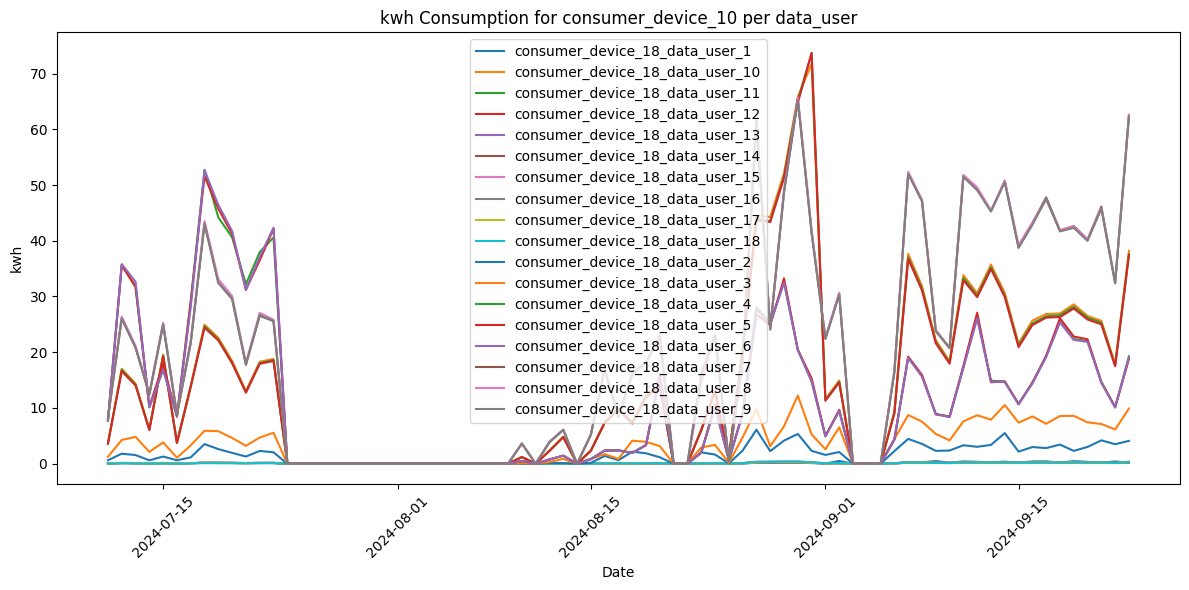

In [106]:
# Filter data for consumer_device_10
consumer_n_data = complete_data[complete_data['Source'].str.contains('consumer_device_18')]

# Create the plot
plt.figure(figsize=(12, 6))
for data_user in consumer_n_data['Source'].unique():
    user_data = consumer_n_data[consumer_n_data['Source'] == data_user]
    plt.plot(user_data['Date'], user_data['kwh'], label=data_user)

plt.xlabel('Date')
plt.ylabel('kwh')
plt.title('kwh Consumption for consumer_device_10 per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


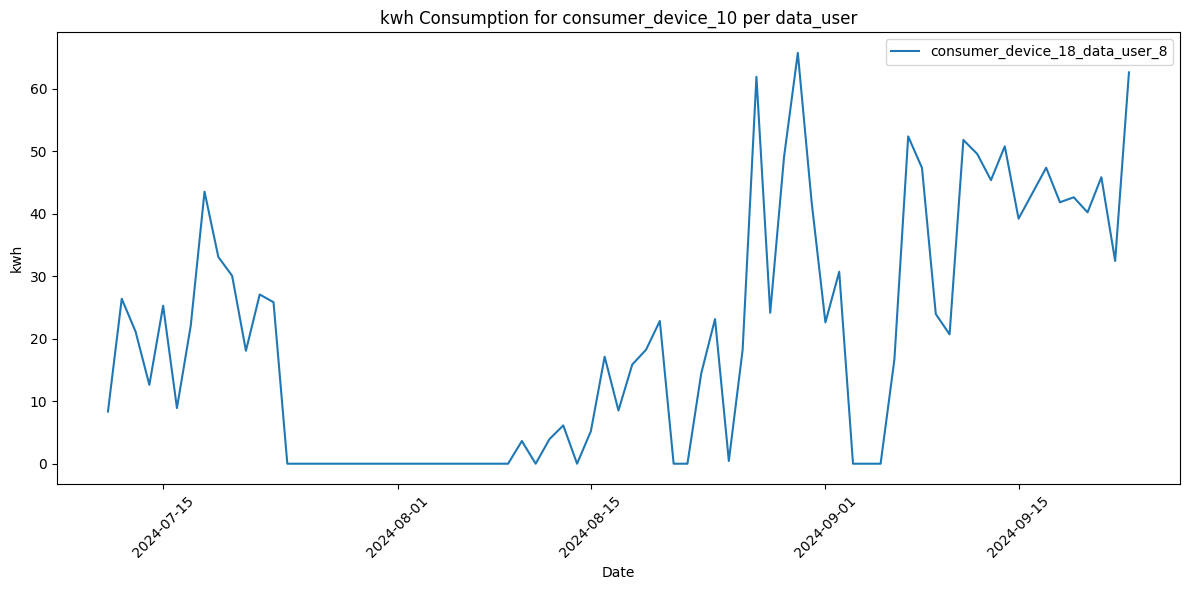

In [105]:
# Filter data for consumer_device_10
consumer_n_data = complete_data[complete_data['Source'].str.contains('consumer_device_18_data_user_8')]

# Create the plot
plt.figure(figsize=(12, 6))
for data_user in consumer_n_data['Source'].unique():
    user_data = consumer_n_data[consumer_n_data['Source'] == data_user]
    plt.plot(user_data['Date'], user_data['kwh'], label=data_user)

plt.xlabel('Date')
plt.ylabel('kwh')
plt.title('kwh Consumption for consumer_device_10 per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


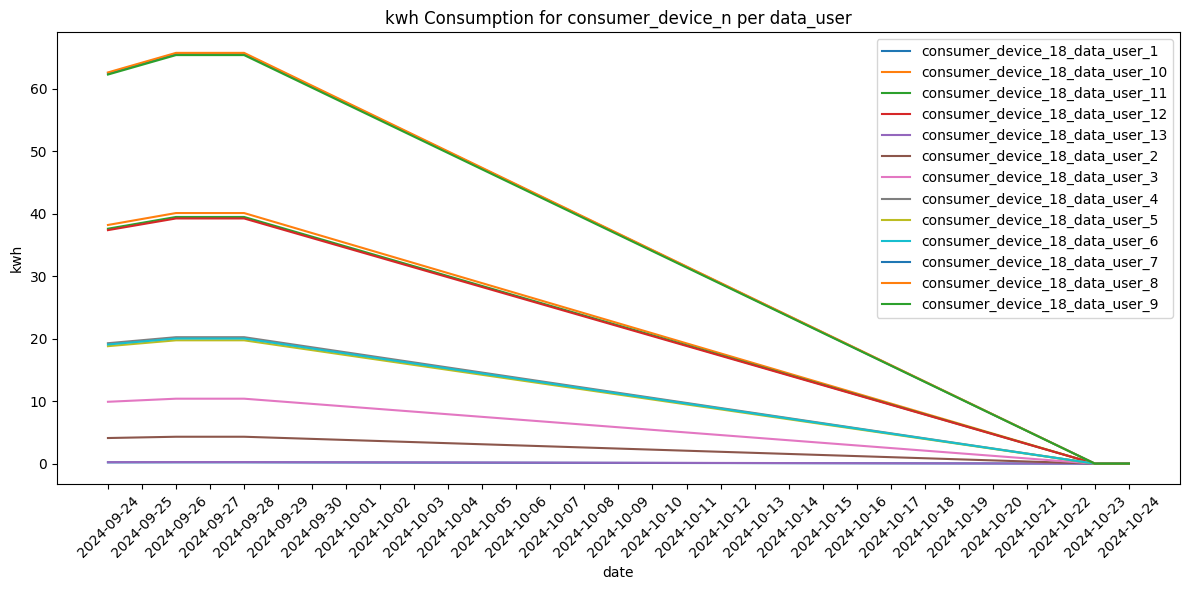

In [158]:
adjusted_max_forecast['date'] = adjusted_max_forecast['ID'].str.extract(r'^(\d{4}-\d{2}-\d{2})')
adjusted_max_forecast['source'] = adjusted_max_forecast['ID'].str.extract(r'^\d{4}-\d{2}-\d{2}_(.+)')
consumer_n_data = adjusted_max_forecast[adjusted_max_forecast['source'].str.contains('consumer_device_18')]

# Create the plot
plt.figure(figsize=(12, 6))
for data_user in consumer_n_data['source'].unique():
    user_data = consumer_n_data[consumer_n_data['source'] == data_user]
    plt.plot(user_data['date'], user_data['kwh'], label=data_user)

plt.xlabel('date')
plt.ylabel('kwh')
plt.title('kwh Consumption for consumer_device_n per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
